### Manifold Learning in Electric Power System Transient Stability Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.cluster import HDBSCAN, KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, TSNE, MDS
from sklearn.manifold import SpectralEmbedding as SE
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Using experimental HalvingRandomSearchCV for hyperparameters optimization.
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV

In [4]:
from scipy import stats

In [5]:
from annealing import simulated_annealing

In [6]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [7]:
# Figure aesthetics
try:
    import seaborn as sns
    sns.set(context='paper', style='white', font_scale=1.1)
    sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})
except ImportError:
    plt.style.use('seaborn-v0_8-paper')

#### Power System Transient Stability Analysis Data (IEEE Benchmark Test Case)

In [8]:
data = pd.read_csv('GridDictionary2.csv')
data.head()

,WmG1,WmG2,WmG3,WmG4,WmG5,WmG6,WmG7,WmG8,WmG9,WmG10,...,VAlvB37,VBlvB37,VClvB37,VAlvB38,VBlvB38,VClvB38,VAlvB39,VBlvB39,VClvB39,Stability
0,1.0012,1.0038,1.0044,1.0019,1.0033,1.0025,1.0021,1.0018,1.0017,1.0027,...,1.06610,1.06610,1.06610,1.08410,1.08410,1.0841,1.0299,1.0299,1.0299,0
1,1.0004,1.0015,1.0007,1.0005,1.0014,1.0008,1.0007,1.0001,1.0002,1.0016,...,1.04680,1.04680,1.04680,1.04500,1.04500,1.0450,1.0103,1.0103,1.0103,0
2,1.0002,1.0018,1.0011,1.0015,1.0026,1.0019,1.0017,1.0029,1.0040,1.0038,...,0.94869,0.94867,0.94872,0.98802,0.98803,0.9880,1.0104,1.0104,1.0104,0
3,1.0007,1.0019,1.0007,1.0009,1.0021,1.0013,1.0012,1.0001,1.0005,1.0018,...,1.07170,1.07170,1.07170,1.07830,1.07830,1.0783,1.0255,1.0255,1.0255,0
4,1.0010,1.0032,1.0025,1.0045,1.0061,1.0079,1.0091,1.0024,1.0023,1.0038,...,1.03960,1.03960,1.03960,1.07580,1.07580,1.0758,1.0099,1.0099,1.0099,0


In [9]:
# print(data.columns.values)

In [10]:
# Percentage of "ones" in the "Stability" column.
print('There is {:.1f}% of unstable cases in the dataset!'
      .format(data['Stability'].sum()/float(len(data['Stability']))*100.))

There is 19.3% of unstable cases in the dataset!


In [11]:
no_features = len(data.columns) - 1
X_data = data.iloc[:, 0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['Stability']
print('y_data', y_data.shape)

X_data (3120, 354)
y_data (3120,)


#### Stratify shuffle split

In [12]:
# Split dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, stratify=y_data, shuffle=True)

In [13]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2496, 354)
y_train (2496,)
X_test (624, 354)
y_test (624,)


In [14]:
print('Unstable cases in training dataset: {:.1f}%:'
      .format(np.sum(y_train)/float(len(y_train))*100.))
print('Unstable cases in testing dataset {:.1f}%:'
      .format(np.sum(y_test)/float(len(y_test))*100.))

Unstable cases in training dataset: 19.3%:
Unstable cases in testing dataset 19.2%:


In [15]:
# Stable cases index values.
idx_stable = y_test==0

##### Scoring models using cross-validated metrics

In [16]:
def score_default(X, y):
    """ Scoring default SVC model. """
    # Score with default hyperparameters.
    scores = cross_val_score(svm.SVC(kernel='rbf', class_weight='balanced'), 
                             X, y, cv=3, scoring='f1', n_jobs=-1)
    print('Score using 3-fold CV: {:g} +/- {:g}'
          .format(np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)

In [17]:
def score_optimized(X, y, C, gamma):
    """ Scoring optimized SVC model. """
    # Score with the optimized hyperparameters.
    scores = cross_val_score(svm.SVC(C=C, gamma=gamma, kernel='rbf', 
                                     class_weight='balanced'), 
                             X, y, cv=3, scoring='f1', n_jobs=-1)
    print('Score using 3-fold CV: {:g} +/- {:g}'
          .format(np.mean(scores), np.std(scores)))
    return np.mean(scores), np.std(scores)

Auxiliary ploting functions

In [18]:
save_figure = True

In [19]:
def plot_projection(X, idx, name=None, save_fig=False):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    ax.scatter(X[idx,0], X[idx,1], s=20, c='seagreen', marker='o', 
               edgecolors='k', alpha=0.6, label='Stable')
    ax.scatter(X[~idx,0], X[~idx,1], s=20, c='firebrick', marker='o', 
               edgecolors='k', alpha=0.6, label='Unstable')
    ax.legend(loc='best')
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.grid()
    fig.tight_layout()
    if save_fig:
        if name is None:
            raise ValueError('Set valid figure name.')
        plt.savefig(name+'.png', dpi=600)
    plt.show()

In [20]:
def plot_side_by_side(X1, X2, idx, left='color', right='color', 
                      name=None, save_fig=False):
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    # Left subplot.
    if left == 'color':
        ax[0].scatter(X1[idx,0], X1[idx,1], s=20, c='seagreen', marker='o', 
                      edgecolors='k', alpha=0.6, label='Stable')
        ax[0].scatter(X1[~idx,0], X1[~idx,1], s=20, c='firebrick', marker='o', 
                      edgecolors='k', alpha=0.6, label='Unstable')
        ax[0].legend(loc='best')
    elif left == 'bw':
        ax[0].scatter(X1[:,0], X1[:,1], s=20, c='dimgrey', marker='o', 
                      edgecolors='k', alpha=0.6)
    else:
        raise ValueError('Wrong "left" argument.')
    ax[0].set_xlabel('First component')
    ax[0].set_ylabel('Second component')
    ax[0].grid()
    # Right subplot.
    if right == 'color':
        ax[1].scatter(X2[idx,0], X2[idx,1], s=20, c='seagreen', marker='o', 
                      edgecolors='k', alpha=0.6, label='Stable')
        ax[1].scatter(X2[~idx,0], X2[~idx,1], s=20, c='firebrick', marker='o', 
                      edgecolors='k', alpha=0.6, label='Unstable')
        ax[1].legend(loc='best')
    elif right == 'bw':
        ax[1].scatter(X2[:,0], X2[:,1], s=20, c='dimgrey', marker='o', 
                      edgecolors='k', alpha=0.6)
    else:
        raise ValueError('Wrong "right" argument.')
    ax[1].set_xlabel('First component')
    ax[1].set_ylabel('Second component')
    ax[1].grid()
    # Save figure.
    fig.tight_layout()
    if save_fig:
        if name is None:
            raise ValueError('Set valid figure name.')
        plt.savefig(name+'.png', dpi=600)
    plt.show()

In [21]:
def plot_clusters(X, labels, name=None, save_fig=False):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    labels = labels if labels is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                # Marker "x" is used for noise.
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4.5,
                alpha=0.6)
    
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    ax.grid(which='major')
    fig.tight_layout()
    if save_fig:
        if name is None:
            raise ValueError('Set valid figure name.')
        plt.savefig(name+'.png', dpi=600)
    plt.show()

In [22]:
def plot_progress(x_params, res, name=None, save_fig=False):
    fig, ax = plt.subplots(2, 1, figsize=(5,4), sharex=True, 
                           height_ratios=[0.6,0.4])
    # Hyperparameters.
    x_params.plot(ax=ax[0])
    ax[0].legend(loc='best')
    #ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Hyperparameters')
    # Objective function.
    ax[1].plot(res)
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Objective function')
    ax[1].set_ylim(-0.98, -0.5)
    fig.tight_layout()
    if save_fig:
        if name is None:
            raise ValueError('Set valid figure name.')
        plt.savefig(name+'.png', dpi=600)
    plt.show()

#### Scaling data using the StandardScaler

In [23]:
# Standardize the input data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### BENCHMARK: Using ALL features with SVM

In [24]:
# Search type: ['random', 'halving']
search = 'random'

estimator = svm.SVC(kernel='rbf', class_weight='balanced', probability=True)
parameters = {
    'C':stats.expon(scale=100), 
    'gamma':stats.expon(scale=.1)
}
if search == 'random':
    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=parameters,
                               n_iter=200,
                               cv=2, scoring='f1',
                               refit=True, n_jobs=-1)
elif search == 'halving':
    # Experimental method.
    model = HalvingRandomSearchCV(estimator=estimator, 
                                  param_distributions=parameters, 
                                  cv=2, scoring='f1',
                                  refit=True, n_jobs=-1)
else:
    raise NotImplementedError(f'Search method: {search} not recognized.')

In [25]:
# Fit the model on a training data set.
model.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=SVC(class_weight='balanced', probability=True),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001928B879C90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001928B9C53D0>},
                   scoring='f1')

In [26]:
scores = cross_val_score(model, X_test, y_test, cv=3, scoring='f1', n_jobs=-1)
print('Average score using 3-fold CV: {:.4f} +/- {:.4f}'
      .format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.9665 +/- 0.0116


### Following dimmensionality reduction methods will be examined:

* **PCA** (principal components analysis)
* **kPCA** (kernelized principal components analysis)
* **tSVD** (truncated singular value decomposition)
* **iMAP** (isomap embedding)
* **t-SNE** (T-distributed stochastic neighbor embedding)
* **LLE** (locally linear embedding)
* **LLE:LTSA** (locally linear embedding with local tangent space alignment algorithm)
* **LLE:H** (locally linear embedding with Hessian eigenmap method)
* **SE** (spectral embedding)
* **MDS** (multi-dimensional scaling)

Some of these have their own hyperparameters (e.g. KernelPCA) which can be optimized together with the hyperparameters of the SVC estimator. This will be shown for the KernelPCA method.

### Hyperparameter optimization with simulated annealing

Simulated annealing is used for optimizing hyperparameters of the SVC estimator only.

In [27]:
def svc_cv(C, gamma, X_data, y_data):
    """ 
    Support Vector Machine Classifier cross-validation.
    
    This function will instantiate a SVC classifier with a 
    RBF kernel and hyper-parameters "C" and "gamma". Combined
    with data and targets it will be used to perform cross-
    validation. The goal is to find combinations of "C" and
    "gamma" that maximizes the `f1` scoring metric.
    
    Parameters
    ----------
    C: float
        Regularization parameter (penalty is a squared l2). 
    gamma: float
        Kernel coefficient.
    X_data: np.array
        Matrix (2d array) of features.
    y_data: np.array
        Vector (1d array) of targets.
    
    Returns
    -------
    cval: float
        Mean value of the score from the cross-validation.
    """
    # Instantiate SVC with RBF kernel and class weight balancing.
    estimator = svm.SVC(C=C, gamma=gamma, kernel='rbf', 
                        class_weight='balanced', probability=True)
    # Score the estimator using cross validation.
    cval = cross_val_score(estimator, X_data, y_data, 
                           scoring='f1', cv=2, n_jobs=-1)
    
    return -cval.mean()

In [28]:
def optimize_svc(X_data, y_data, x0, bounds=None, sigma=0.5, 
                 fs=0.1, burn=10, eps=1e-8, tol=1e-6, **kwargs):
    """ 
    Simulated Annealing to optimize SVC hyperparameters. 
    
    Parameters
    ----------
    X_data: np.array
        Matrix (2d array) of features.
    y_data: np.array
        Vector (1d array) of targets.
    x0: np.array or list
        Initial values for the variables of the energy function.
        For example, if the energy functions is f(x,y), then
        initial values are given as [x0, y0], where x0 is the 
        initial value for the variable x and y0 for the variable
        y. Order of array elements is important!
    bounds: list of tuples or None, default=None
        List of two-element tuples which define bounds on energy 
        function variables. The number and order of list elements
        is the same as for the array `x0` for the initial values.
        For example, if the energy function is f(x,y), then 
        bounds are defined as follows: [(xl,xu), (yl,yu)], where
        xl, xu are, respectively, lower and upper bounds for the
        variable x, and yl, yu represnt the same limits for the
        variable y. Order of tuples in the list is important!
    sigma: float, default=0.5
        Standard deviation of a statistical distribution for
        the random walk by which new candidates are generated. 
    fs: float, default=0.1
        Factor for reducing the standard deviation of a statisti-
        cal distribution used for the random walk (see parameter
        `sigma` above for more information). Default value halves
        the `sigma` after the burn-in.    
    burn: int, default=10
        Number of iterations with the original step size of
        the random walk from the Student's t distribution, after
        which the step size is reduced approximately by a factor
        of 10 by switching over to the Normal distribution with
        a lower standard deviation (see parameter `sigma` above).
    eps: float, default=1e-8
        Temperature value at which the algorithm is stopped.
    tol : float, default=1e-3
        Tolerance for considering that absolute difference between 
        two successive energy function evaluations is small enough
        that it has not improved further.
    **kwargs : dict
        Additional arguments passed to the function.
    
    Returns
    -------
    results : dict
        Result is a dictionary holding the following keys:
        'x' : np.array
            Coordinate values (i.e. parameters) of the energy 
            function's optimum point.
        'E' : float
            Energy function's optimal value.
        'x_all' : np.array
            Return the list of all x-values.
        'E_all' : np.array
            Return the list of all E-values.
    """
    
    def svc_crossval(expC, expGamma):
        """ 
        Wrapper for the SVC cross-validation function.

        Parameters
        ----------
        expC: float
            Log value of the SVC regularization parameter. 
        expGamma: float
            Log value of the SVC's RBF kernel coefficient.
        
        Returns
        -------
        cv_score: float
            Negative value of the cross-validated score.
        """
        # Exploring parameters in 'log' space.
        C = 10**expC
        gamma = 10**expGamma
        cv_score = svc_cv(C, gamma, X_data, y_data)
        
        return cv_score

    # Simulated Annealing.
    res = simulated_annealing(svc_crossval, x0, bounds=bounds,
                              sigma=sigma, fs=fs, burn=burn,
                              eps=eps, tol=tol, **kwargs)
    
    return res

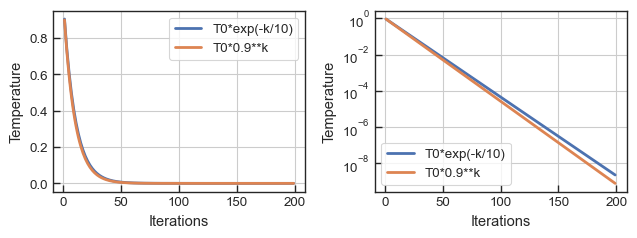

In [29]:
# Temperature schedule.
x = np.arange(start=1, stop=200, step=1)
T0 = 1.
y1 = T0*np.exp(-x/10)
y2 = T0*0.9**(x)
fig, ax = plt.subplots(1, 2, figsize=(6.5,2.5))
ax[0].plot(x, y1, lw=2, label='T0*exp(-k/10)')
ax[0].plot(x, y2, lw=2, label='T0*0.9**k')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Temperature')
ax[0].legend(loc='upper right')
ax[0].grid()
ax[1].semilogy(x, y1, lw=2, label='T0*exp(-k/10)')
ax[1].semilogy(x, y2, lw=2, label='T0*0.9**k')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Temperature')
ax[1].legend(loc='lower left')
ax[1].grid(which='both')
fig.tight_layout()
plt.show()

In [30]:
# Initial values (C, gamma) for SVC optimization.
x0 = np.array([1.5, -2.])

In [31]:
# Dictionary for holding model scores.
scores_table = {}
# Dictionary for holding SVM parameters.
svm_table = {}

#### BENCHMARK: No. PCA components for 90% explained variance

In [32]:
# How many components are needed for the 90% explained variance?
pca = PCA(n_components=0.9, svd_solver='full').fit(X_train)
X_pca = pca.transform(X_test)
print(X_pca.shape)
# Score with the 90% explained variance.
mu, sigma = score_default(X_pca, y_test)

(624, 7)
Score using 3-fold CV: 0.933681 +/- 0.0213506


### Principal components analysis (PCA)

In [33]:
# Dimensionality reduction.
# Set `whiten` to True/False to see if there is any difference.
pca = PCA(n_components=2, whiten=True).fit(X_train)
X_pca = pca.transform(X_test)

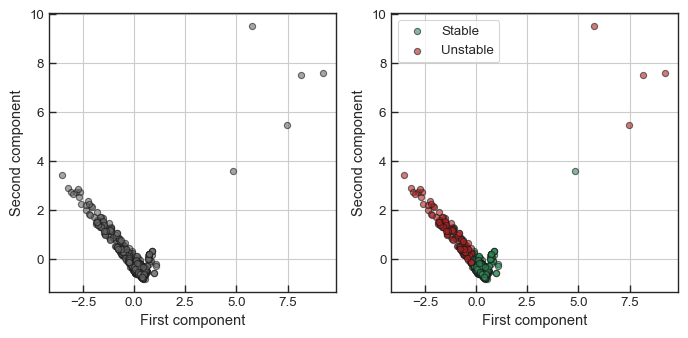

In [34]:
plot_side_by_side(X_pca, X_pca, idx_stable, left='bw', right='color')

In [35]:
mu, sigma = score_default(X_pca, y_test)
scores_table['PCA_default'] = [mu, sigma]

Score using 3-fold CV: 0.884756 +/- 0.0241787


In [124]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_pca, y_test, x0, bounds=[(-1,3), (-4,1)], 
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['PCA'] = res['x']

iter. 3: u_bound
iter. 4: u_bound
iter. 5: l_bound
iter. 7: u_bound
iter. 8: u_bound
iter. 9: u_bound
iter. 13: u_bound
iter. 17: l_bound
iter. 29: u_bound
Early stopping after 75 iterations.
Final temperature: 5.531e-04 after 75 iterations.
[-0.0594989  -1.69070384] -0.9098179133858267


In [125]:
mu, sigma = score_optimized(X_pca, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['PCA_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.903291 +/- 0.0274413


### Dimensionality reduction using KernelPCA

Hyperparameters of the KernelPCA are optimized by means of the **unsupervised** learning.

In [126]:
def kpca_metric(X_data, gamma=None):
    """
    Distance metric for the kPCA.

    Parameters
    ----------
    X_data : np.array
        Matrix (2d array) of features.
    gamma : float
        Kernel value for the kPCA RBF kernel.
    
    Returns
    -------
    mse : float
        Mean square error between the original features 
        and their reconstruction after embedding and its 
        inversion.
    """
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma,
                     fit_inverse_transform=True, n_jobs=-1)
    X_embedded = kpca.fit_transform(X_data)
    X_reconstructed = kpca.inverse_transform(X_embedded)

    # Compute mean squared error between embedding and its reconstruction.
    mse = mean_squared_error(X_data, X_reconstructed)
    
    return mse

In [127]:
def optimize_kpca(X_data, x0, bounds=None, sigma=0.5,
                  fs=0.1, burn=10, eps=1e-8, tol=1e-6, **kwargs):
    """ Simulated Annealing for kPCA hyperparameters. """

    def kpca(expGamma):
        # Exploring parameters in 'log' space.
        gamma_kpca = 10**expGamma
        distance = kpca_metric(X_data, gamma=gamma_kpca)
        
        return distance

    # Simulated Annealing.
    res = simulated_annealing(kpca, x0, bounds=bounds, 
                              sigma=sigma, fs=fs, burn=burn,
                              eps=eps, tol=tol, **kwargs)
    
    return res

In [128]:
# Initial value for the Gamma-kPCA
xk0 = np.array([-2.])
# Optimize kPCA hyperparameters using simulated annealing.
res = optimize_kpca(X_train, xk0, bounds=[(-4,1)],
                    burn=2*10, C=10, eps=1e-10, 
                    sigma=[5/5], fs=0.1, 
                    wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])

iter. 18: u_bound
iter. 46: l_bound
iter. 53: l_bound
iter. 57: l_bound
iter. 60: l_bound
iter. 63: l_bound
iter. 65: l_bound
Final temperature: 9.285e-11 after 232 iterations.
[-2.48088764] 0.7351393042106453


In [129]:
# Fit kPCA on the train set and transform the test set.
kpca_opt = KernelPCA(n_components=2, kernel='rbf', 
                     gamma=10**res['x'][0], # optimal kernel value
                     n_jobs=-1).fit(X_train)
X_kpca_opt = kpca_opt.transform(X_test)

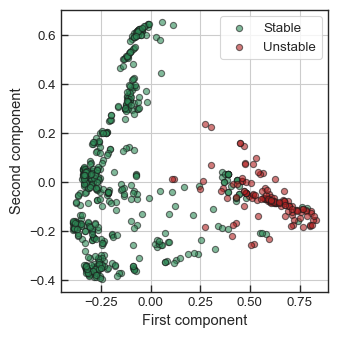

In [130]:
plot_projection(X_kpca_opt, idx_stable, name='kpca_single', save_fig=save_figure)

Clustering on top of the unsupervised kPCA projection

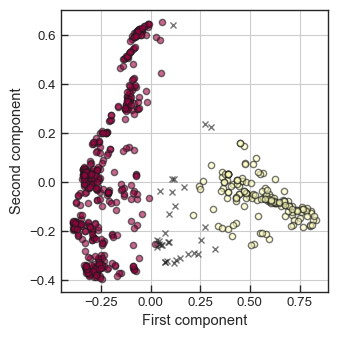

In [131]:
# HDBSCAN on top of the projection from the unsuprvised kPCA.
hdb = HDBSCAN(min_cluster_size=50, metric='euclidean', n_jobs=-1).fit(X_kpca_opt)
labels = hdb.labels_
plot_clusters(X_kpca_opt, labels)

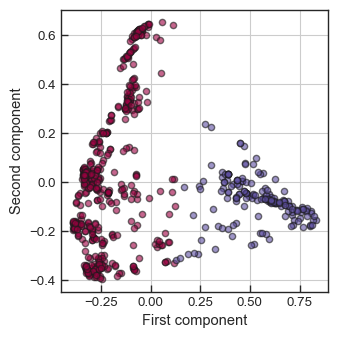

In [132]:
# KMeans on top of the projection from the unsuprvised kPCA.
kmeans = KMeans(n_clusters=2).fit(X_kpca_opt)
labels = kmeans.labels_
plot_clusters(X_kpca_opt, labels, name='kpca_clusters', save_fig=save_figure)

In [133]:
mu, sigma = score_default(X_kpca_opt, y_test)
scores_table['kPCA_unsuperv_default'] = [mu, sigma]

Score using 3-fold CV: 0.841511 +/- 0.0179803


In [134]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_kpca_opt, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['kPCA_un'] = res['x']

iter. 10: u_bound
iter. 12: u_bound
iter. 24: u_bound
iter. 32: u_bound
iter. 34: u_bound
Early stopping after 34 iterations.
Final temperature: 3.337e-02 after 34 iterations.
[0.68531225 0.46505022] -0.8480671261612227


In [135]:
mu, sigma = score_optimized(X_kpca_opt, y_test, 
                            C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['kPCA_unsuperv_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.845652 +/- 0.0220689


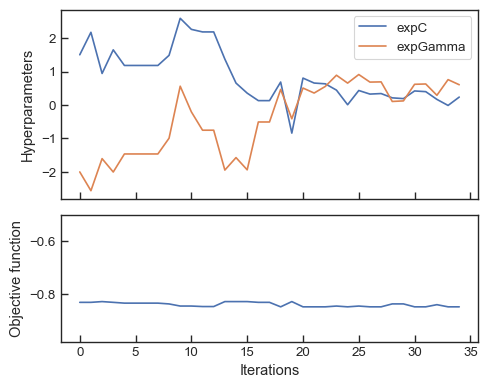

In [136]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='kpca_unsuperv_params', save_fig=save_figure)

In [137]:
# Optimize using RandomSearch for comparison.
# A `model` is a reserved instance created previously.
model.fit(X_kpca_opt, y_test)
bp = model.best_params_
print(bp, model.best_score_)
m, s = score_optimized(X_kpca_opt, y_test, C=bp['C'], gamma=bp['gamma'])
scores_table['kPCA_unsuperv_random_search'] = [m, s]

{'C': 69.85112126458316, 'gamma': 0.651379838619826} 0.8480671261612227
Score using 3-fold CV: 0.838762 +/- 0.0218367


Simulated annealing is here used for optimizing the hyperparameters of the KernelPCA and the SVC estimator **at the same time**, using the **supervised** learning.

In [138]:
def kpca_svc_cv(C, gamma, gamma_kpca, X_data, y_data):
    """ 
    SVC cross-validation with KernelPCA. 
    
    Parameters
    ----------
    C: float
        Regularization parameter of the SVC. 
    gamma: float
        Kernel coefficient of the SVC RBF kernel.
    gamma_kpca; float
        Kernel coefficient of the kPCA RBF kernel.
    X_data: np.array
        Matrix (2d array) of features.
    y_data: np.array
        Vector (1d array) of targets.
    
    Returns
    -------
    cval: float
        Mean value of the score from the cross-validation.
    """
    # Instantiate SVC with RBF kernel and class weight balancing.
    estimator = svm.SVC(C=C, gamma=gamma, kernel='rbf', 
                        class_weight='balanced', probability=True)
    # Instantiate kPCA with RBF kernel.
    reduction = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_kpca)
    # Create a pipeline.
    pipe = Pipeline([
        ('kpca', reduction),
        ('svm', estimator)
    ])
    # Score the pipeline using cross-validation.
    cval = cross_val_score(pipe, X_data, y_data, 
                           scoring='f1', cv=2, n_jobs=-1)
    
    return -cval.mean()

In [139]:
def optimize_kpca_svc(X_data, y_data, x0, bounds=None,
                      sigma=0.5, fs=0.1, burn=10, 
                      eps=1e-8, tol=1e-6, **kwargs):
    """ Simulated Annealing for SVC & kPCA hyperparameters. """

    def kpca_svc_crossval(expC, expGamma, expGammkPCA):
        """ 
        Wrapper for the cross-validation function. 
        
        Parameters
        ----------
        expC: float
            Log value of the SVC regularization parameter. 
        expGamma: float
            Log value of the SVC's RBF kernel coefficient.
        expGammkPCA: float
            Log value of the kPCA's RBF kernel coefficient.

        Returns
        -------
        cv_score: float
            Negative value of the cross-validated score.        
        """
        # Exploring parameters in 'log' space.
        C = 10**expC
        gamma = 10**expGamma
        gamma_kpca = 10**expGammkPCA
        cv_score = kpca_svc_cv(C, gamma, gamma_kpca, X_data, y_data)
        
        return cv_score

    # Simulated Annealing.
    res = simulated_annealing(kpca_svc_crossval, x0, bounds=bounds,
                              sigma=sigma, fs=fs, burn=burn, 
                              eps=eps, tol=tol, **kwargs)
    
    return res

In [140]:
# Initial values (C-SVM, Gamma-SVM, Gamma-kPCA)
xk0 = np.array([1.5, -2., -2.])
# Optimize kPCA & SVC hyperparameters using simulated annealing.
res = optimize_kpca_svc(X_train, y_train, 
                        xk0, bounds=[(-1,3), (-4,1), (-4,1)],
                        burn=2*10, C=10, eps=1e-10, 
                        sigma=[4/5, 5/5, 5/5], fs=0.1, 
                        wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])

iter. 0: u_bound
iter. 3: l_bound
iter. 7: l_bound
iter. 10: l_bound
iter. 13: l_bound
iter. 30: l_bound
iter. 32: u_bound
iter. 34: u_bound
iter. 42: l_bound
iter. 43: l_bound
iter. 51: l_bound
iter. 54: u_bound
iter. 56: l_bound
iter. 59: l_bound
iter. 69: u_bound
iter. 72: l_bound
iter. 73: l_bound
iter. 76: l_bound
iter. 91: l_bound
iter. 92: l_bound
iter. 106: u_bound
iter. 109: u_bound
iter. 183: u_bound
iter. 186: u_bound
iter. 187: u_bound
iter. 198: u_bound
iter. 202: u_bound
iter. 204: u_bound
iter. 205: u_bound
iter. 206: u_bound
iter. 209: u_bound
iter. 211: u_bound
iter. 212: u_bound
iter. 213: u_bound
iter. 216: u_bound
iter. 217: u_bound
iter. 219: u_bound
iter. 220: u_bound
iter. 220: u_bound
iter. 222: u_bound
iter. 223: u_bound
iter. 224: u_bound
iter. 225: u_bound
iter. 225: u_bound
iter. 226: u_bound
iter. 227: u_bound
iter. 227: u_bound
iter. 228: u_bound
iter. 229: u_bound
iter. 231: u_bound
Final temperature: 9.285e-11 after 232 iterations.
[ 2.89691095  0.940801

In [141]:
kpca_pipe_opt = KernelPCA(n_components=2, kernel='rbf', 
                          gamma=10**res['x'][2], # optimal kernel value
                          n_jobs=-1).fit(X_train)
X_kpca_pipe_opt = kpca_opt.transform(X_test)

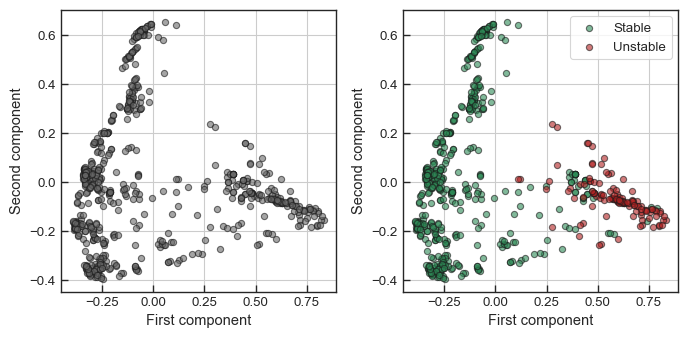

In [142]:
plot_side_by_side(X_kpca_pipe_opt, X_kpca_pipe_opt, idx_stable,
                  left='bw', right='color', name='kpca-pipe', 
                  save_fig=save_figure)

In [143]:
mu, sigma = score_default(X_kpca_pipe_opt, y_test)
scores_table['kPCA_pipe_default'] = [mu, sigma]

Score using 3-fold CV: 0.841511 +/- 0.0179803


In [144]:
mu, sigma = score_optimized(X_kpca_pipe_opt, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['kPCA_pipe_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.853052 +/- 0.028327


#### KernelPCA without the kPCA kernel optimization

In [145]:
# Reduce features in the dataset down to only 2 principal components.
kpca = KernelPCA(n_components=2, kernel='rbf', n_jobs=-1).fit(X_train)
X_kpca = kpca.transform(X_test)

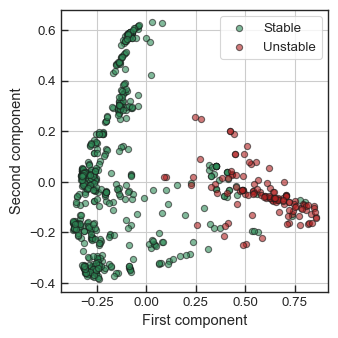

In [146]:
plot_projection(X_kpca, idx_stable)

In [147]:
mu, sigma = score_default(X_kpca, y_test)
scores_table['kPCA_default'] = [mu, sigma]

Score using 3-fold CV: 0.837443 +/- 0.023691


In [150]:
# Apply bounds on SVC hyperparameters in log-space.
# Parameter C: 0.001 to 10000.
# Parameter gamma: 0.0001 to 10.
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_kpca, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['kPCA'] = res['x']

iter. 7: u_bound
iter. 10: l_bound
iter. 16: u_bound
iter. 20: u_bound
iter. 24: u_bound
iter. 31: u_bound
iter. 32: u_bound
iter. 35: u_bound
iter. 41: u_bound
iter. 46: u_bound
iter. 51: u_bound
iter. 53: u_bound
Early stopping after 60 iterations.
Final temperature: 2.479e-03 after 60 iterations.
[2.86605523 0.91205622] -0.8509050492219752


In [151]:
mu, sigma = score_optimized(X_kpca, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['kPCA_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.849806 +/- 0.0259209


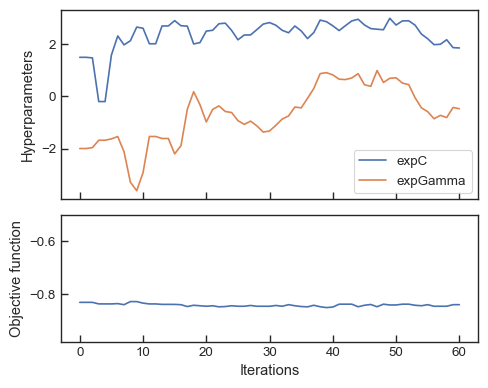

In [152]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='kpca_parameters', save_fig=save_figure)

#### Random Search CV for SVC hyperparameters optimization.

In [153]:
# Search type: ['random', 'halving']
search = 'random'

reduction = KernelPCA(n_components=2, kernel='rbf')
estimator = svm.SVC(kernel='rbf', class_weight='balanced', probability=True)
pipe = Pipeline([
    ('kpca', reduction),
    ('svm', estimator)
])
parameters = {
    'kpca__gamma': stats.expon(scale=.1),
    'svm__C':stats.expon(scale=100), 
    'svm__gamma':stats.expon(scale=.1)
}
if search == 'random':
    pipe_model = RandomizedSearchCV(estimator=pipe,
                                    param_distributions=parameters,
                                    n_iter=200,
                                    cv=2, scoring='f1',
                                    refit=True, n_jobs=-1)
elif search == 'halving':
    # Experimental method.
    pipe_model = HalvingRandomSearchCV(estimator=pipe, 
                                       param_distributions=parameters, 
                                       cv=2, scoring='f1',
                                       refit=True, n_jobs=-1)
else:
    raise NotImplementedError(f'Search method: {search} not recognized.')

In [154]:
pipe_model.fit(X_train, y_train)
pipe_model.best_params_

C:\Users\Dino Lovrić\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


{'kpca__gamma': 0.0005029199744171976,
 'svm__C': 199.36084196393605,
 'svm__gamma': 0.10650450253851602}

In [155]:
scores = cross_val_score(pipe_model, X_test, y_test, cv=3, scoring='f1', n_jobs=-1)
print('Average score using 3-fold CV: {:.4f} +/- {:.4f}'
      .format(np.mean(scores), np.std(scores)))
scores_table['kPCA_pipe_random_search'] = [np.mean(scores), np.std(scores)]

Average score using 3-fold CV: 0.8772 +/- 0.0531


### Dimensionality reduction using truncated SVD

In [156]:
svd = TruncatedSVD(n_components=2).fit(X_train)
X_svd = svd.transform(X_test)

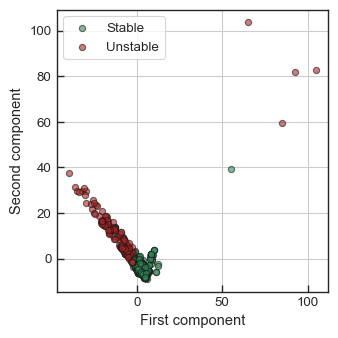

In [157]:
plot_projection(X_svd, idx_stable)

In [158]:
mu, sigma = score_default(X_svd, y_test)
scores_table['SVD_default'] = [mu, sigma]

Score using 3-fold CV: 0.884756 +/- 0.0241787


In [159]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_svd, y_test, x0, bounds=[(-1,3), (-4,1)], 
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['SVD'] = res['x']

iter. 1: l_bound
iter. 6: l_bound
iter. 14: l_bound
iter. 15: l_bound
iter. 19: u_bound
iter. 21: l_bound
iter. 27: l_bound
iter. 28: l_bound
iter. 39: l_bound
Early stopping after 43 iterations.
Final temperature: 1.357e-02 after 43 iterations.
[ 0.08838458 -3.93640387] -0.9134424603174603


In [160]:
mu, sigma = score_optimized(X_svd, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['SVD_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.906677 +/- 0.0239717


### Isomap embedding

In [161]:
iso = Isomap(n_components=2, n_neighbors=100, n_jobs=-1).fit(X_train)
X_iso = iso.transform(X_test)

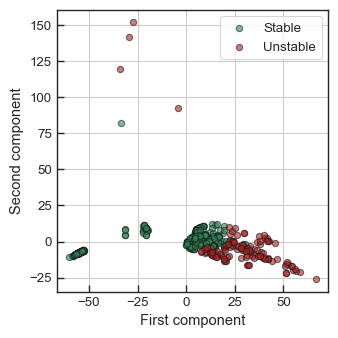

In [162]:
plot_projection(X_iso, idx_stable, name='isomap', save_fig=save_figure)

In [163]:
mu, sigma = score_default(X_iso, y_test)
scores_table['ISO_default'] = [mu, sigma]

Score using 3-fold CV: 0.88644 +/- 0.00822525


In [164]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_iso, y_test, x0, bounds=[(-1,3), (-4,1)], 
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['ISO'] = res['x']

iter. 1: u_bound
iter. 10: u_bound
iter. 16: l_bound
iter. 26: l_bound
iter. 30: l_bound
iter. 41: l_bound
iter. 42: u_bound
iter. 54: l_bound
Early stopping after 65 iterations.
Final temperature: 1.503e-03 after 65 iterations.
[ 2.6177933  -2.16874407] -0.9676097303014277


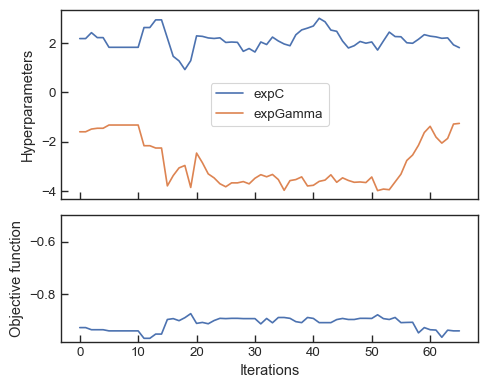

In [165]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='isomap_parameters', save_fig=save_figure)

In [166]:
mu, sigma = score_optimized(X_iso, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['ISO_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.956015 +/- 0.0345263


In [167]:
# Optimize using RandomSearch for comparison.
# A `model` is a reserved instance created previously.
model.fit(X_iso, y_test)
bp = model.best_params_
print(bp, model.best_score_)
m, s = score_optimized(X_iso, y_test, C=bp['C'], gamma=bp['gamma'])
scores_table['ISO_random_search'] = [m, s]

{'C': 106.89702955404212, 'gamma': 0.011271826539016669} 0.9638032786885246
Score using 3-fold CV: 0.959839 +/- 0.0345475


### t-distributed Stochastic Neighbor Embedding (t-SNE)

#### t-SNE with optimized hyperparameters

Here hyperparameters of the t-SNE (i.e. `perplexity`) is optimized using the **unsupervised** learning.

In [168]:
def tsne_metric(perplex, X_data):
    """ t-SNE metric based on the KL divergence. """
    from numpy import log

    reduction = TSNE(n_components=2, perplexity=perplex, n_jobs=-1)
    # Score the estimator.
    cval = reduction.fit(X_data)

    kl = cval.kl_divergence_
    n = float(X_data.shape[0])
    parameters = reduction.get_params(deep=False)
    perp = parameters['perplexity']

    metric = 2*kl + log(n)*(perp/n)
    
    return metric

In [169]:
def optimize_tsne(X_data, x0, bounds=None, sigma=0.5, 
                  fs=0.1, burn=10, eps=1e-6, tol=1e-6, **kwargs):
    """ Simulated Annealing for t-SNE hyperparameters. """

    def tsne(expPerplex):
        from numpy import exp

        # Exploring parameter perplexity in natural logarithm (ln) space.
        perplex = exp(expPerplex)
        # KL divergence based score.
        kl_metric = tsne_metric(perplex, X_data)
        
        return kl_metric

    # Simulated Annealing.
    res = simulated_annealing(tsne, x0, bounds=bounds, 
                              sigma=sigma, fs=fs, burn=burn, 
                              eps=eps, tol=tol, **kwargs)
    
    return res

In [170]:
# Initial values (perplexity)
xt0 = np.array([3.])
# Optimize t-SNE hyperparameters using simulated annealing.
res = optimize_tsne(X_train, xt0, bounds=[(0.,4.5)], 
                    burn=2*10, C=10, eps=1e-10, 
                    sigma=[4.5/5], fs=0.1, 
                    wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])

iter. 4: u_bound
iter. 11: u_bound
iter. 12: u_bound
iter. 17: l_bound
iter. 18: u_bound
iter. 45: u_bound
iter. 64: u_bound
Final temperature: 9.285e-11 after 232 iterations.
[2.35525157] 0.7077171026155026


In [171]:
X_tsne_opt = TSNE(n_components=2, 
                  perplexity=np.exp(res['x'][0]), # optimal value
                  n_jobs=-1).fit_transform(X_test)

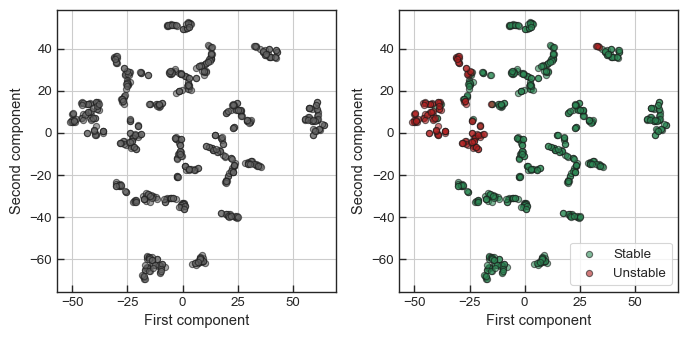

In [172]:
plot_side_by_side(X_tsne_opt, X_tsne_opt, idx_stable, 
                  left='bw', right='color',
                  name='tsne', save_fig=save_figure)

Clustering on top of the t-SNE projection

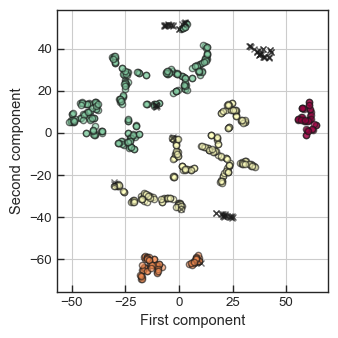

In [173]:
# HDBSCAN on top of the t-SNE projection.
hdb = HDBSCAN(min_cluster_size=30, metric='euclidean', n_jobs=-1).fit(X_tsne_opt)
labels = hdb.labels_
plot_clusters(X_tsne_opt, labels)

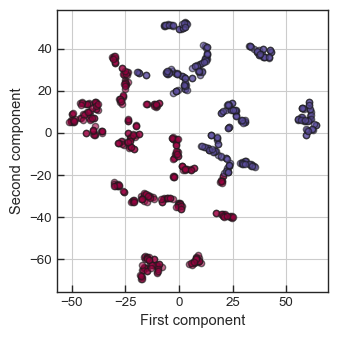

In [174]:
# KMeans on top of the t-SNE projection.
kmeans = KMeans(n_clusters=2).fit(X_tsne_opt)
labels = kmeans.labels_
plot_clusters(X_tsne_opt, labels)

In [175]:
mu, sigma = score_default(X_tsne_opt, y_test)
scores_table['tSNE_unsuperv_default'] = [mu, sigma]

Score using 3-fold CV: 0.857238 +/- 0.0474957


In [176]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_tsne_opt, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['tSNE'] = res['x']

iter. 10: u_bound
iter. 14: l_bound
iter. 18: l_bound
Early stopping after 42 iterations.
Final temperature: 1.500e-02 after 42 iterations.
[ 1.62120326 -2.15022289] -0.9401904761904762


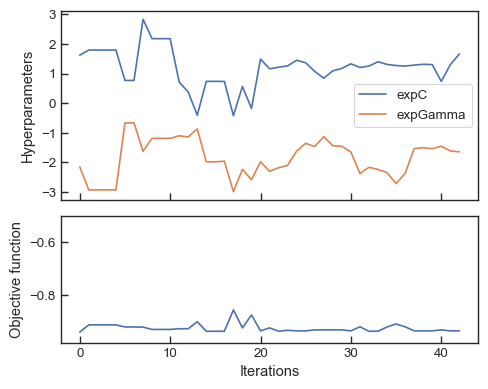

In [177]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='tsne_parameters', save_fig=save_figure)

In [178]:
mu, sigma = score_optimized(X_tsne_opt, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['tSNE_unsuperv_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.929213 +/- 0.00905593


#### t-SNE without hyperparameters optimization

Hyperparameters of the t-SNE are not being optimized.

In [179]:
# Default 'perplexity' value
X_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(X_test)

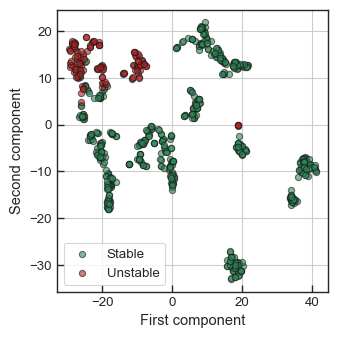

In [180]:
plot_projection(X_tsne, idx_stable)

In [181]:
mu, sigma = score_default(X_tsne, y_test)
scores_table['tSNE_wo_default'] = [mu, sigma]

Score using 3-fold CV: 0.879122 +/- 0.0363211


In [182]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_tsne, y_test, x0, bounds=[(-1,3), (-4,1)], 
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['tSNE_wo'] = res['x']

iter. 3: l_bound
iter. 17: u_bound
Early stopping after 67 iterations.
Final temperature: 1.231e-03 after 67 iterations.
[ 1.268995   -1.22966162] -0.9399767651994321


In [183]:
mu, sigma = score_optimized(X_tsne, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['tSNE_wo_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.931139 +/- 0.00609515


### Locally Linear Embedding (LLE)

In [213]:
lle = LLE(n_components=2, n_neighbors=14, 
          method='standard', n_jobs=-1).fit(X_train)
X_lle = lle.transform(X_test)

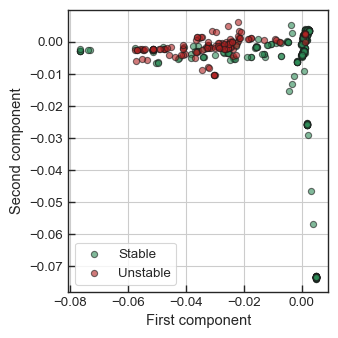

In [214]:
plot_projection(X_lle, idx_stable, name='lle', save_fig=False)

In [215]:
mu, sigma = score_default(X_lle, y_test)
scores_table['LLE_default'] = [mu, sigma]

Score using 3-fold CV: 0.74712 +/- 0.0624411


In [216]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_lle, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.10, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['LLE'] = res['x']

iter. 1: u_bound
iter. 5: u_bound
iter. 6: u_bound
iter. 10: u_bound
iter. 11: u_bound
iter. 15: l_bound
iter. 19: u_bound
Early stopping after 64 iterations.
Final temperature: 1.662e-03 after 64 iterations.
[ 2.28145886 -1.10606859] -0.7666083916083917


In [217]:
mu, sigma = score_optimized(X_lle, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['LLE_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.758739 +/- 0.0649542


In [218]:
# Optimize using RandomSearch for comparison.
# A `model` is a reserved instance created previously.
model.fit(X_lle, y_test)
bp = model.best_params_
print(bp, model.best_score_)
m, s = score_optimized(X_lle, y_test, C=bp['C'], gamma=bp['gamma'])
scores_table['LLE_random_search'] = [m, s]

{'C': 8.880604484542372, 'gamma': 0.03382794583688354} 0.7666083916083917
Score using 3-fold CV: 0.75656 +/- 0.0676259


### Locally linear embedding with LTSA

In [219]:
ltsa = LLE(n_components=2, n_neighbors=80, 
           method='ltsa', eigen_solver='dense', n_jobs=-1).fit(X_train)
X_ltsa = ltsa.transform(X_test)

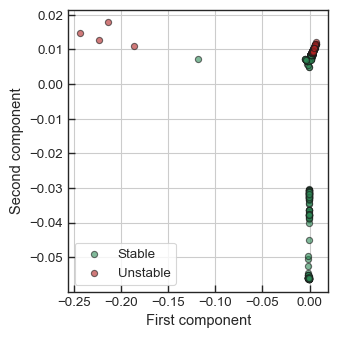

In [220]:
plot_projection(X_ltsa, idx_stable, name='ltsa', save_fig=False)

In [221]:
mu, sigma = score_default(X_ltsa, y_test)
scores_table['TSA_default'] = [mu, sigma]

Score using 3-fold CV: 0.890706 +/- 0.00587725


In [224]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_ltsa, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['TSA'] = res['x']

iter. 8: u_bound
iter. 9: u_bound
iter. 11: u_bound
iter. 12: l_bound
iter. 19: u_bound
Early stopping after 44 iterations.
Final temperature: 1.228e-02 after 44 iterations.
[2.64935283 0.52615332] -0.7907284768211921


In [225]:
mu, sigma = score_optimized(X_ltsa, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['TSA_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.891453 +/- 0.0267346


### Locally linear embedding with Hessian

In [226]:
hess = LLE(n_components=2, n_neighbors=114, 
           method='hessian', n_jobs=-1).fit(X_train)
X_hess = hess.transform(X_test)

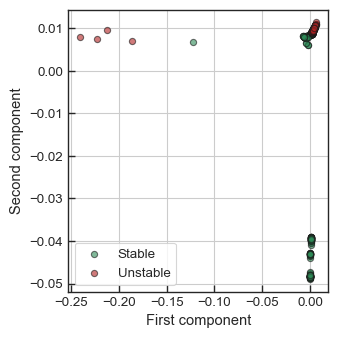

In [227]:
plot_projection(X_hess, idx_stable, name='lle_hes', save_fig=save_figure)

In [228]:
mu, sigma = score_default(X_hess, y_test)
scores_table['HES_default'] = [mu, sigma]

Score using 3-fold CV: 0.871964 +/- 0.0622111


In [235]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_hess, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['HES'] = res['x']

iter. 3: l_bound
iter. 4: l_bound
iter. 5: u_bound
iter. 14: u_bound
iter. 15: u_bound
iter. 19: u_bound
Early stopping after 30 iterations.
Final temperature: 4.979e-02 after 30 iterations.
[2.67979628 0.71885577] -0.5096474817504859


In [236]:
mu, sigma = score_optimized(X_hess, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['HES_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.870212 +/- 0.0473882


### Modified locally linear embedding (MLLE)

In [237]:
mlle = LLE(n_components=2, n_neighbors=50, 
           method='modified', n_jobs=-1).fit(X_train)
X_mlle = lle.transform(X_test)

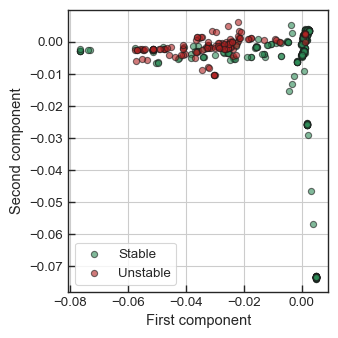

In [238]:
plot_projection(X_mlle, idx_stable, name='mlle', save_fig=False)

In [239]:
mu, sigma = score_default(X_mlle, y_test)
scores_table['MLE_default'] = [mu, sigma]

Score using 3-fold CV: 0.74712 +/- 0.0624411


In [242]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_mlle, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['MLE'] = res['x']

iter. 2: u_bound
iter. 15: u_bound
iter. 37: u_bound
Early stopping after 39 iterations.
Final temperature: 2.024e-02 after 39 iterations.
[ 2.04717516 -0.84318041] -0.7614714053070217


In [243]:
mu, sigma = score_optimized(X_mlle, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['MLE_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.753929 +/- 0.0676763


### Spectral embedding

In [244]:
X_spec = SE(n_components=2, affinity='nearest_neighbors', 
            n_jobs=-1).fit_transform(X_test)

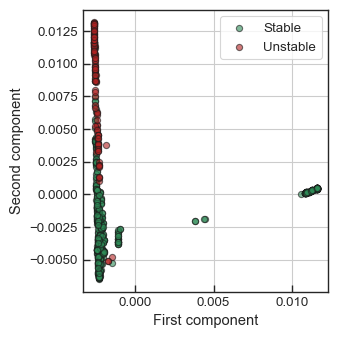

In [245]:
plot_projection(X_spec, idx_stable, name='spectral', save_fig=save_figure)

In [246]:
mu, sigma = score_default(X_spec, y_test)
scores_table['SPE_default'] = [mu, sigma]

Score using 3-fold CV: 0.797269 +/- 0.0297476


In [247]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_spec, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['SPE'] = res['x']

iter. 1: u_bound
iter. 3: u_bound
iter. 9: u_bound
iter. 12: u_bound
iter. 22: u_bound
iter. 26: u_bound
Early stopping after 99 iterations.
Final temperature: 5.017e-05 after 99 iterations.
[1.36844809 0.93062789] -0.8227320125130344


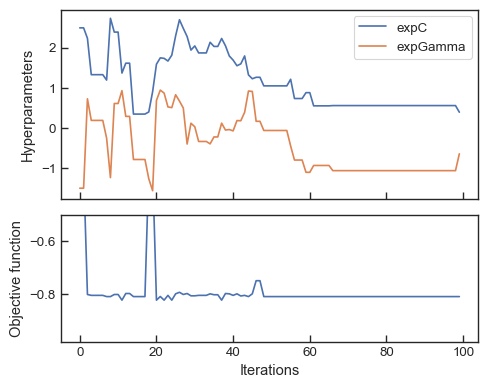

In [248]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='spectral_params', save_fig=False)

In [249]:
mu, sigma = score_optimized(X_spec, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['SPE_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.82141 +/- 0.0344406


### Multi-dimensional scaling (MDS)

In [250]:
# Set `metric` to True/False to see if there is any difference.
X_mds = MDS(n_components=2, metric=True, n_jobs=-1).fit_transform(X_test)

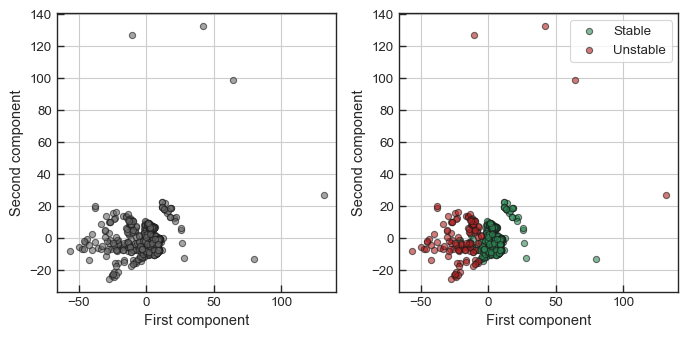

In [251]:
plot_side_by_side(X_mds, X_mds, idx_stable, left='bw', right='color', 
                  name='mds', save_fig=save_figure)

In [252]:
mu, sigma = score_default(X_mds, y_test)
scores_table['MDS_default'] = [mu, sigma]

Score using 3-fold CV: 0.94144 +/- 0.01585


In [256]:
# Optimize SVC hyperparameters using simulated annealing.
res = optimize_svc(X_mds, y_test, x0, bounds=[(-1,3), (-4,1)],
                   burn=2*10, C=10, eps=1e-10, 
                   sigma=[4/5, 5/5], fs=0.1, 
                   wait=10, tol=1e-8, verbose=True)
print(res['x'], res['E'])
svm_table['MDS'] = res['x']

iter. 6: l_bound
iter. 12: l_bound
iter. 30: l_bound
iter. 36: l_bound
iter. 37: l_bound
iter. 40: l_bound
iter. 41: l_bound
Early stopping after 64 iterations.
Final temperature: 1.662e-03 after 64 iterations.
[ 1.18696882 -3.44538453] -0.9375


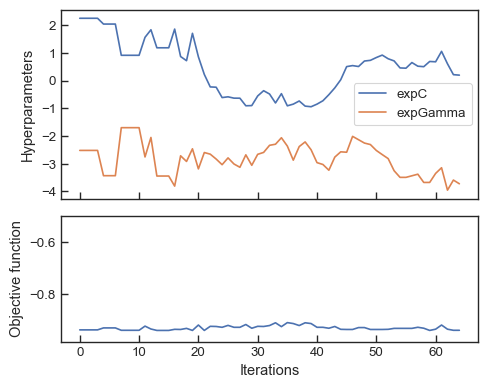

In [257]:
# Plot optimization progress (convergence).
x_params = pd.DataFrame(data=res['x_all'], columns=['expC', 'expGamma'])
plot_progress(x_params, res['E_all'], name='mds_parameters', save_fig=save_figure)

In [258]:
mu, sigma = score_optimized(X_mds, y_test, C=10**res['x'][0], gamma=10**res['x'][1])
scores_table['MDS_optimal'] = [mu, sigma]

Score using 3-fold CV: 0.93311 +/- 0.0133253


In [259]:
# Optimize using RandomSearch for comparison.
# A `model` is a reserved instance created previously.
model.fit(X_mds, y_test)
bp = model.best_params_
print(bp, model.best_score_)
m, s = score_optimized(X_mds, y_test, C=bp['C'], gamma=bp['gamma'])
scores_table['MDS_random_search'] = [m, s]

{'C': 17.002233788321927, 'gamma': 0.005661846621490633} 0.9375
Score using 3-fold CV: 0.928661 +/- 0.0349828


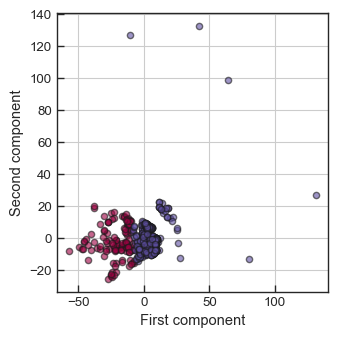

In [260]:
# KMeans on top of the projection from the unsuprvised kPCA.
kmeans = KMeans(n_clusters=2).fit(X_mds)
labels = kmeans.labels_
plot_clusters(X_mds, labels, name='mds_clusters', save_fig=False)

In [261]:
# Aggregate scores from all models into a dataframe.
pdscores = pd.DataFrame(data=scores_table)
pdscores = pdscores.transpose()
pdscores.columns = ['Mean', 'Std']
pdscores

,Mean,Std
PCA_default,0.884756,0.024179
PCA_optimal,0.903291,0.027441
kPCA_unsuperv_default,0.841511,0.017980
kPCA_unsuperv_optimal,0.845652,0.022069
kPCA_unsuperv_random_search,0.838762,0.021837
kPCA_pipe_default,0.841511,0.017980
kPCA_pipe_optimal,0.853052,0.028327
kPCA_default,0.837443,0.023691
kPCA_optimal,0.849806,0.025921
kPCA_pipe_random_search,0.877191,0.053069


In [262]:
# Aggregate hyperparameters from different SVMs into a dataframe.
svms = pd.DataFrame(data=svm_table)
svms = svms.transpose()
svms.columns = ['C', 'Gamma']
# Convert back from the log-scale.
svms = svms.apply(lambda x: 10**x)
svms

,C,Gamma
PCA,0.871969,0.020384
kPCA_un,4.845206,2.917764
kPCA,734.607280,8.166881
SVD,1.225701,0.000116
ISO,414.756593,0.006780
tSNE,41.802597,0.007076
tSNE_wo,18.577831,0.058930
LLE,191.187222,0.078331
TSA,446.018459,3.358562
HES,478.405630,5.234266


### Precision-Recall Tradeoff for a selected model

In [263]:
# Select SVC model here from the following list:
# ['PCA', 'kPCA_un', 'kPCA', 'SVD', 'ISO', 'tSNE', 'tSNE_wo', 'LLE',
#  'TSA', 'HES', 'MLE', 'SPE', 'MDS']
model = 'kPCA'
C = svms['C'].loc[model]
gamma = svms['Gamma'].loc[model]
best_parameters = {'C': C, 'gamma': gamma}

In [264]:
y_probas = cross_val_predict(svm.SVC(**best_parameters, probability=True, 
                                     class_weight='balanced'), 
                             X_test, y_test, cv=3, 
                             method='predict_proba',
                             n_jobs=-1)

In [265]:
y_scores = y_probas[:,1]  # score == probability of positive class
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores)

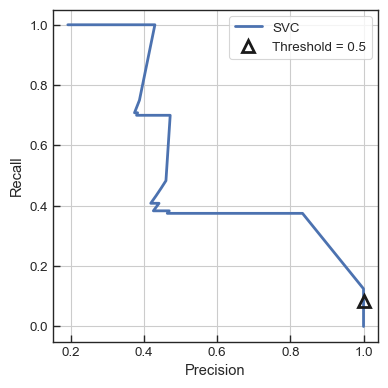

In [266]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(precisions, recalls, lw=2, label='SVC')
default = np.argmin(np.abs(thresholds - 0.5))
ax.plot(precisions[default], recalls[default], '^', c='k', markersize=8, 
        label='Threshold = 0.5', fillstyle='none', mew=2)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
if save_figure:
        plt.savefig(model+'_threshold.png', dpi=600)
plt.show()

#### Plot decision region for the selected model

In [267]:
# Projected data (X_test) that is consistent 
# with the previously selected model.
if model == 'PCA':
    X_test_mod = X_pca
elif model == 'kPCA_un':
    X_test_mod = X_kpca_pipe_opt
elif model == 'kPCA':
    X_test_mod = X_kpca
elif model == 'SVD':
    X_test_mod = X_svd
elif model == 'ISO':
    X_test_mod = X_iso
elif model == 'tSNE':
    X_test_mod = X_tsne_opt
elif model == 'tSNE_wo':
    X_test_mod = X_tsne
elif model == 'LLE':
    X_test_mod = X_lle
elif model == 'TSA':
    X_test_mod = X_ltsa
elif model == 'HES':
    X_test_mod = X_hess
elif model == 'MLE':
    X_test_mod = X_mlle
elif model == 'SPE':
    X_test_mod = X_spec
elif model == 'MDS':
    X_test_mod = X_mds
else:
    raise NotImplementedError(f'Model designation: {model} not recognized!')

In [268]:
# Generate SVC from the selected projection and
# associated optimized model parameters.
svc_best = svm.SVC(C=C, gamma=gamma, kernel='rbf', 
                   class_weight='balanced', 
                   probability=True).fit(X_test_mod, y_test)

In [269]:
h = 0.1; delta = 0.1
x_min, x_max = X_test_mod[:,0].min() - h, X_test_mod[:,0].max() + h
y_min, y_max = X_test_mod[:,1].min() - h, X_test_mod[:,1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = svc_best.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

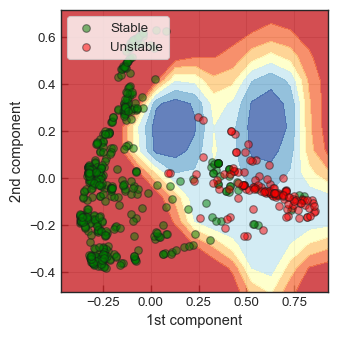

In [270]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
ax.scatter(X_test_mod[idx_stable,0], X_test_mod[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_test_mod[~idx_stable,0], X_test_mod[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
# Re-set limits if needed.
#ax.set_xlim(right=70)
#ax.set_ylim(top=70)
ax.grid()
fig.tight_layout()
if save_figure:
        plt.savefig(model+'_decisions.png', dpi=600)
plt.show()

#### Computing environment

In [271]:
import sys, IPython, sklearn, scipy, matplotlib, pandas, numpy
print("Notebook createad with:\
      \nPython {:s}\nIPython {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy \
      {:s}\nScipy {:s}\nMatplotlib {:s}"\
      .format(sys.version[:5], IPython.__version__, sklearn.__version__, 
              pandas.__version__, numpy.__version__, scipy.__version__, 
              matplotlib.__version__))

Notebook createad with:      
Python 3.11.
IPython 8.14.0
Scikit-learn 1.3.1
Pandas 2.1.1
Numpy       1.25.0
Scipy 1.11.3
Matplotlib 3.7.2
